In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Random Walk:

A random walk tells when there is equal chnage of going the values/price up or down by a random number.

time series expression:yt = C + yt–1 + ϵt

for simplicity keep C as 0

then yt = yt–1 + ϵt

lets start y0=0

then y1 = y0 + ϵ1    ----y0=0
y1=ϵ1-----1

for t=2
y2 = y1 + ϵ2        -----y1=ϵ1
y2=ϵ1+ϵ2


y3 = y2 + ϵ3 = ϵ1 + ϵ2 + ϵ3
......

sum of ϵ from t ranging from 0 to n


# Simulating the Random Walk

In [7]:
np.random.seed(42)
steps=np.random.standard_normal(1000)
steps[0]=0
random_walk=np.cumsum(steps)

Text(0, 0.5, 'Value')

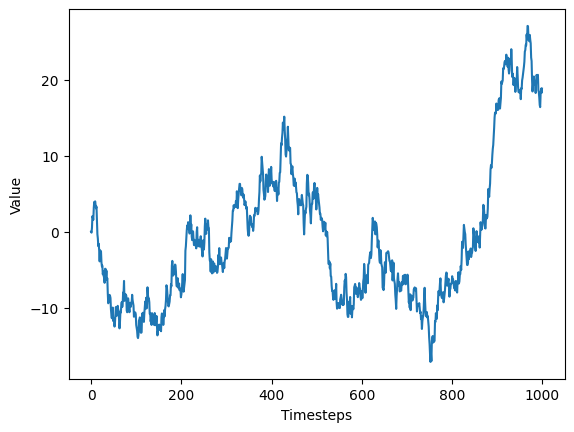

In [9]:
fig,ax=plt.subplots()
ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

Arandom walk is a series whose first difference is stationary and uncorelated, that means completly random

# Statoinarity

It will not change its properities over the time, that menas mean,variance and autocorelation is independent of time


Many forecasting models assume stationarity. The moving average model autoregressive model , and autoregressive moving average model all assume stationarity. These models can only be used if we verify that the data is indeed stationary. Otherwise, the models will not be valid, and the forecasts will not be reliable. Intuitively, this makes sense, because if the data is non-stationary, its properties are going to change over time, which would mean that our model parameters must also change through time. This means that we cannot possibly derive a function of future values as a function of past values, since the coefficients change at each point in time, making forecasting unreliable.

if the time series is not stationary we need to apply transformation(process which stablizes the mean and variance)

differencing: is a mentod of the trianformation which is applied to stablizing the mean
log: is a mentod of the trianformation which is applied to stablizing the variance

Once we apply the transformation we need to chec the is it stationary or not by applying ADF

The ADF test verifies the following:

null hypothesis: there is a unit root present in a time series, then it is non stationary

Alternative hypothesis is that there is no unit root, and therefore the time series is stationary. 

The result of this test is the ADF statistic, which is a negative number. The more negative it is, the stronger the rejection of the null hypothesis. In its implementation in Python, the p-value is also returned. If its value is less than 0.05, we can also reject the null hypothesis and say the series is stationary.


yt = C + α1yt–1 + ϵt

ϵt represents some error that we cannot predict, and C is a constant. Here, α1 is the root of the time series. This time series will be stationary only if the root lies within the unit circle. Therefore, its value must be between –1 and 1. Otherwise the series is non-stationary.



In [15]:
def stationary_check(is_stat:bool):
    np.random.seed(42)
    process = np.empty(400)
    
    if is_stat:
        alpha=0.5
        process[0]=0
    else:
        alpha=1
        process[0]=1
        
    for i in range(400):
        if i+1<400:
           process[i+1]= alpha*process[i]+np.random.standard_normal()
        else:
            break
    return process

In [16]:
stationary = stationary_check(True)
non_stationary = stationary_check(False)

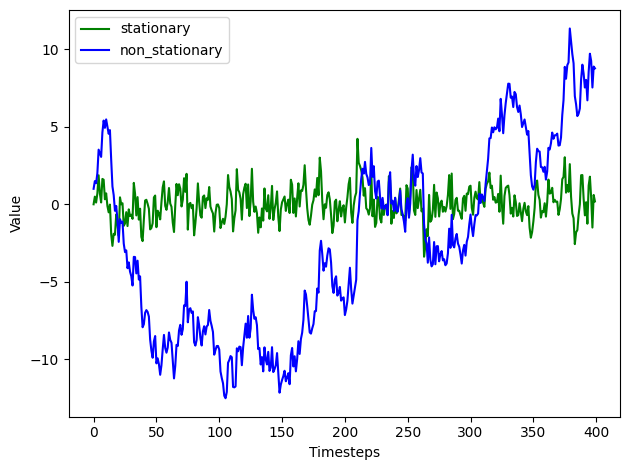

In [18]:
fig,ax=plt.subplots()

ax.plot(stationary,'g-',label='stationary')
ax.plot(non_stationary,'b-',label='non_stationary')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.legend(loc=2)

plt.tight_layout()

in the above graph we can see that when the root is between -1 and +1 then the data is stationary

In [19]:
def avg_mean(prc):
    mean_data=[]
    for i in range(len(prc)):
        mean_data.append(np.mean(prc[:i]))
    return mean_data

In [20]:
stationary_mean=avg_mean(stationary)
non_stationary_mean=avg_mean(non_stationary) 

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


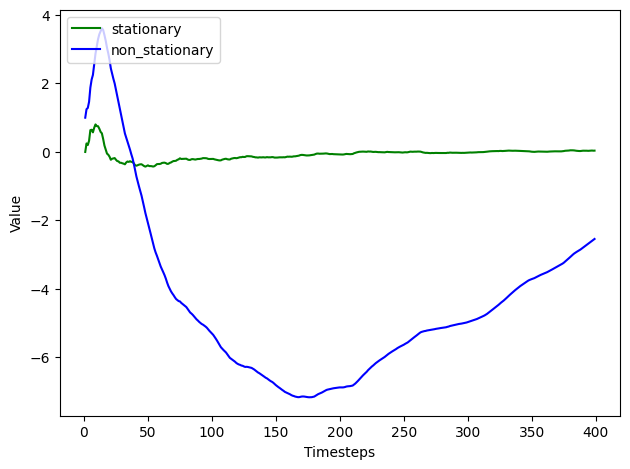

In [21]:
fig,ax=plt.subplots()

ax.plot(stationary_mean,'g-',label='stationary')
ax.plot(non_stationary_mean,'b-',label='non_stationary')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.legend(loc=2)

plt.tight_layout()

In the above graph we can understant that after few steps the mean of the stationary became constant which is expected behiviour in contrast the non stationary mean over the time changing

all the above steps are done just to verify to use the ADF whcih will test the presence of the unit root for the given time serie

Once we have a stationary series, we must determine whether there is autocorrelation or not. Remember that a random walk is a series whose first difference is stationary and uncorrelated. The ADF test takes care of the stationarity portion, but we’ll need to use the autocorrelation function to determine if the series is correlated or not.

# Autocorelation

We know that correlation measures the extent of a linear relationship between two variables. Autocorrelation therefore measures the linear relationship between lagged values of a time series. Thus, the ACF reveals how the correlation between any two values changes as the lag increases. Here, the lag is simply the number of timesteps separating two values.

The autocorrelation function (ACF) measures the linear relationship between lagged values of a time series.

In other words, it measures the correlation of the time series with itself.

# Putting all together

In [24]:
ADF_result = adfuller(random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.965952487691875
p-value: 0.7654789696692581


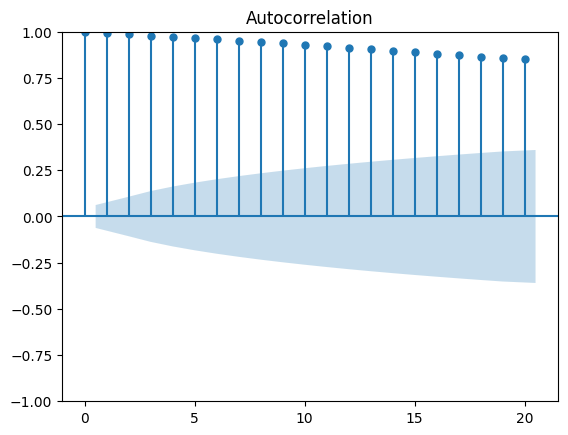

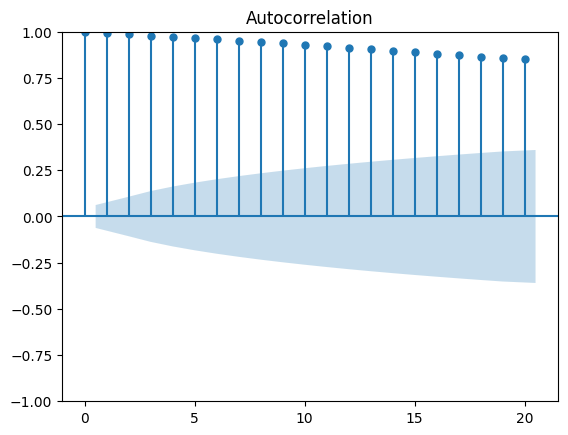

In [26]:
plot_acf(random_walk,lags=20)

in the above graph we notice that the acf points are gradually decreasing so our random walk is not stationary, so we have to do the transformation 

In [27]:
random_walk_diff=np.diff(random_walk,n=1)

In [28]:
ADF_result = adfuller(random_walk_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -31.789310857560594
p-value: 0.0


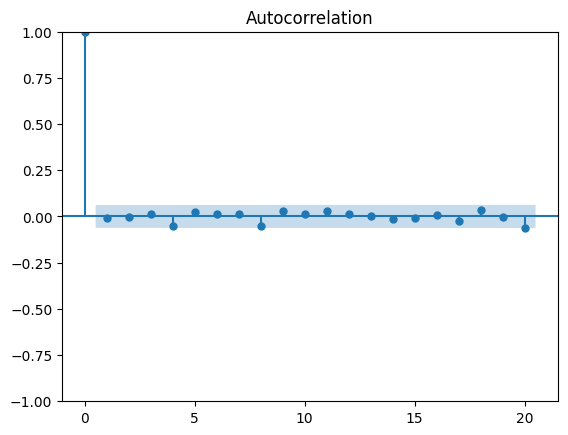

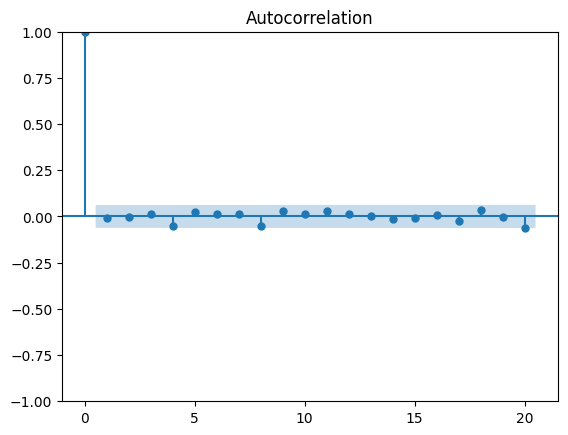

In [29]:
plot_acf(random_walk_diff,lags=20)

from the above graph after differenceing we cannot find any coefficent after diff 1 and lag 0 so it is evident that we are deling with the random walk

note: at lag 0 the ACF is 1 because corelation with itself is always 1

# Google stock price is a random walk?

In [30]:
google_data=pd.read_csv("https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/GOOGL.csv")

In [31]:
google_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,1292.000000,1294.099976,1265.060059,1270.859985,1270.859985,2209300
1,2020-04-28,1283.199951,1284.760010,1230.380005,1232.589966,1232.589966,4035000
2,2020-04-29,1345.000000,1360.150024,1326.729980,1342.180054,1342.180054,5417900
3,2020-04-30,1331.359985,1350.000000,1321.500000,1346.699951,1346.699951,2792100
4,2020-05-01,1324.089966,1351.430054,1309.660034,1317.319946,1317.319946,2443600


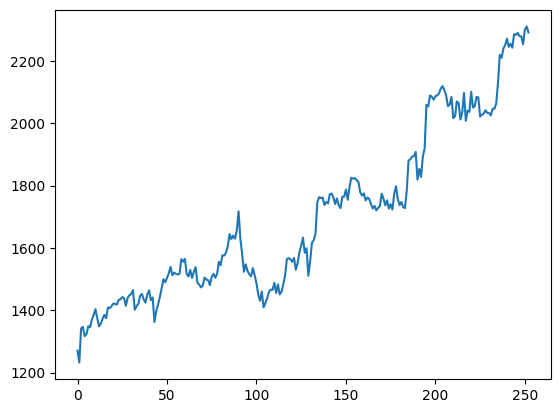

In [32]:
fig,ax=plt.subplots()

ax.plot(google_data['Close'])

In [37]:
GOOGL_ADF_result = adfuller(google_data['Close'])

print(f'ADF Statistic: {GOOGL_ADF_result[0]}')
print(f'p-value: {GOOGL_ADF_result[1]}')


ADF Statistic: 0.16025048664771302
p-value: 0.9699419435913057


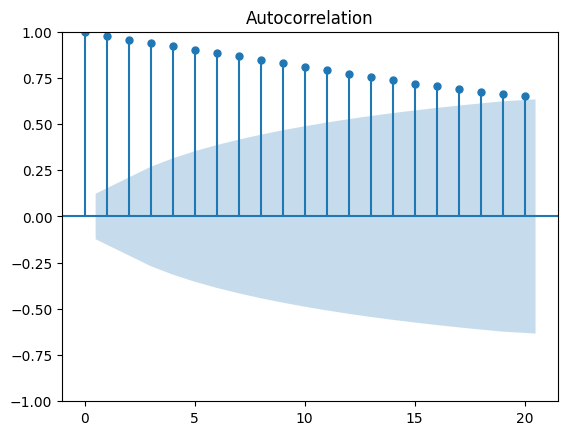

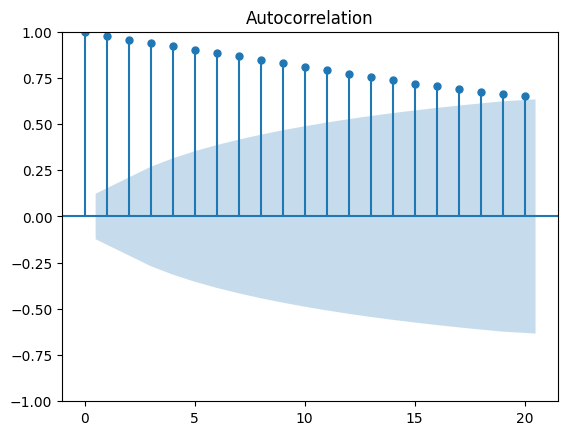

In [38]:
plot_acf(google_data['Close'],lags=20)

ADF Statistic: -5.303439704295234
p-value: 5.3865309614545585e-06


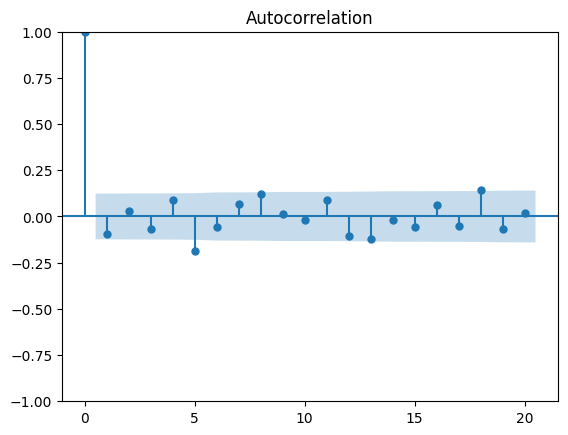

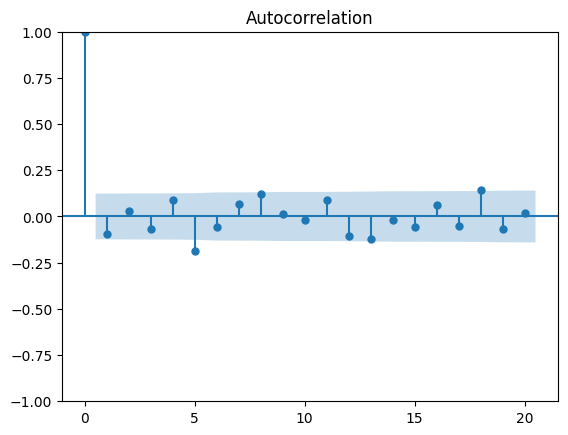

In [41]:
google_data_diff=np.diff(google_data['Close'],1)

GOOGL_ADF_result = adfuller(google_data_diff)

print(f'ADF Statistic: {GOOGL_ADF_result[0]}')
print(f'p-value: {GOOGL_ADF_result[1]}')

plot_acf(google_data_diff,lags=20)

it clrearly stats its a random walk but there is some cases at lag 5 nad lag 18 that is they are by chance and non sigfinent since there is no continuity between 0-5 and 0-18

# Forecasting a random walk

In [42]:
df = pd.DataFrame({'value': random_walk})

train = df[:800]
test = df[800:]

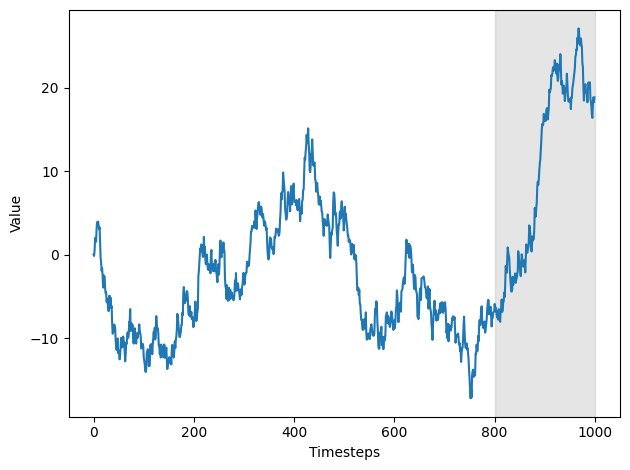

In [44]:
fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.axvspan(800, 1000, color='#808080', alpha=0.2)

plt.tight_layout()

In [45]:
mean = np.mean(train.value)

test.loc[:, 'pred_mean'] = mean

test.head()

,value,pred_mean
800,-5.876664,-3.677206
801,-6.392708,-3.677206
802,-6.296588,-3.677206
803,-6.758863,-3.677206
804,-7.193359,-3.677206


In [46]:
last_value = train.iloc[-1].value

test.loc[:, 'pred_last'] = last_value

test.head()

,value,pred_mean,pred_last
800,-5.876664,-3.677206,-6.814947
801,-6.392708,-3.677206,-6.814947
802,-6.296588,-3.677206,-6.814947
803,-6.758863,-3.677206,-6.814947
804,-7.193359,-3.677206,-6.814947


In [47]:
deltaX = 800 - 1
deltaY = last_value - 0

drift = deltaY / deltaX

x_vals = np.arange(801, 1001, 1)

pred_drift = drift * x_vals

test.loc[:, 'pred_drift'] = pred_drift

test.head()

,value,pred_mean,pred_last,pred_drift
800,-5.876664,-3.677206,-6.814947,-6.832006
801,-6.392708,-3.677206,-6.814947,-6.840536
802,-6.296588,-3.677206,-6.814947,-6.849065
803,-6.758863,-3.677206,-6.814947,-6.857594
804,-7.193359,-3.677206,-6.814947,-6.866124


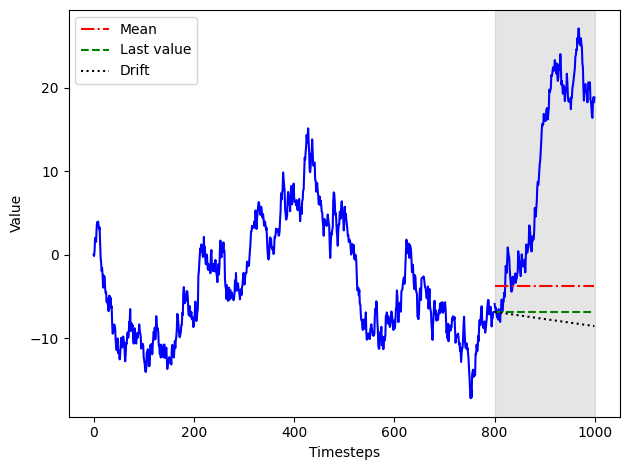

In [48]:
fig, ax = plt.subplots()

ax.plot(train.value, 'b-')
ax.plot(test['value'], 'b-')
ax.plot(test['pred_mean'], 'r-.', label='Mean')
ax.plot(test['pred_last'], 'g--', label='Last value')
ax.plot(test['pred_drift'], 'k:', label='Drift')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

In [49]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last'])
mse_drift = mean_squared_error(test['value'], test['pred_drift'])

print(mse_mean, mse_last, mse_drift)

326.50277395297474 425.1726033055617 466.2172769077409


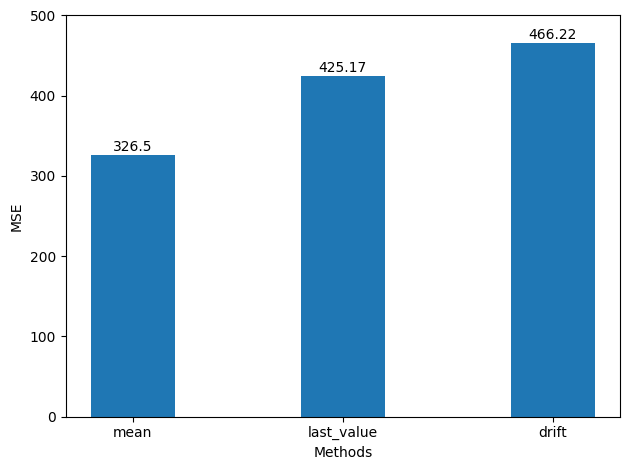

In [50]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'drift']
y = [mse_mean, mse_last, mse_drift]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 500)

for index, value in enumerate(y):
    plt.text(x=index, y=value+5, s=str(round(value, 2)), ha='center')

plt.tight_layout()

# Forecasting the next timestep

In [51]:
df_shift = df.shift(periods=1)

df_shift.head()

,value
0,NaN
1,0.000000
2,-0.138264
3,0.509424
4,2.032454


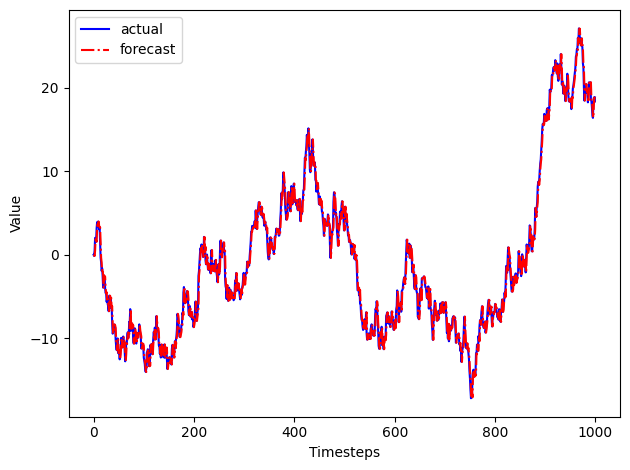

In [53]:
fig, ax = plt.subplots()

ax.plot(df, 'b-', label='actual')
ax.plot(df_shift, 'r-.', label='forecast')

ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()


In [54]:
mse_one_step = mean_squared_error(test['value'], df_shift[800:])

mse_one_step

0.9256876651440581

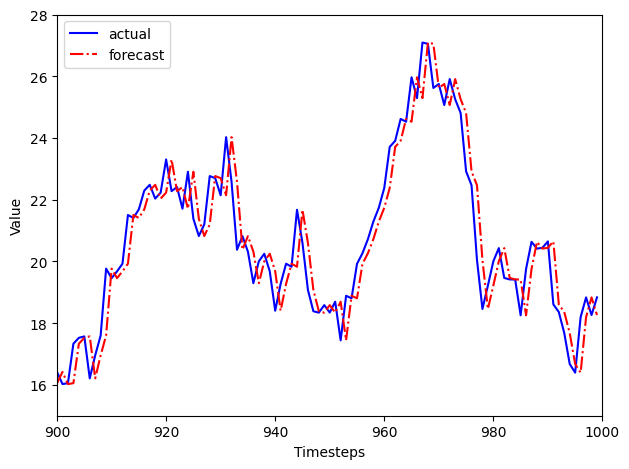

In [56]:
fig, ax = plt.subplots()

ax.plot(df, 'b-', label='actual')
ax.plot(df_shift, 'r-.', label='forecast')

ax.legend(loc=2)

ax.set_xlim(900, 1000)
ax.set_ylim(15, 28)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()



A random walk is a process where the first difference is stationary and not autocorrelated.

We cannot use statistical or deep learning techniques on a random walk, since it moves at random in the future. Therefore, we must use naive forecasts.

A stationary time series is one whose statistical properties (mean, variance, autocorrelation) do not change over time.

The augmented Dickey-Fuller (ADF) test is used to assess stationarity by testing for unit roots.

The null hypothesis of the ADF test is that there is a unit root in the series. If the ADF statistic is a large negative value and the p-value is less than 0.05, the null hypothesis is rejected, and the series is stationary.

Transformations are used to make a series stationary. Differencing can stabilize the trend and seasonality, while logarithms stabilize the variance.

Autocorrelation measures the correlation between a variable and itself at a previous timestep (lag). The autocorrelation function (ACF) shows how the autocorrelation changes as a function of the lag.

Ideally, we will forecast a random walk in the short term or the next timestep. That way, we do not allow for random numbers to accumulate, which will degrade the quality of our forecasts in the long term.